# Imports and setting up viz

NB : conda env1 on Mac, lam1env on spirit (Python3.12)

In [9]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import cartopy.crs as ccrs
import cartopy
import matplotlib as mpl
from matplotlib.colors import ListedColormap
%matplotlib inline

In [10]:
plt.rcParams.update(
        {
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'font.size': 12,
            'figure.dpi': 72.0,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.size': 5.0,
            'xtick.minor.size': 2.5,
            'ytick.major.size': 5.0,
            'ytick.minor.size': 2.5,
            'xtick.minor.visible': True,
            'ytick.minor.visible': True,
            'axes.grid': True,
            'axes.titlesize': 'larger',
            'axes.labelsize': 'larger',
            'grid.color': 'dimgray',
            'grid.linestyle': '-',
            'grid.alpha': 0.3,
            'axes.prop_cycle': cycler(
                color=[
                    '#0C5DA5',
                    '#FF9500',
                    '#00B945',
                    '#FF2C00',
                    '#845B97',
                    '#474747',
                    '#9E9E9E',
                ]
            ) * cycler(alpha=[0.8]),
            'scatter.marker': 'x',
            'lines.linewidth': 1.0,
        })

In [11]:
rivers = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',edgecolor=(0, 0, 0, 0.3), facecolor='none')

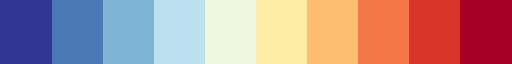

In [12]:
#define centered colorbar
emb = ListedColormap(mpl.colormaps['RdYlBu_r'](np.linspace(0, 1, 10)))
emb

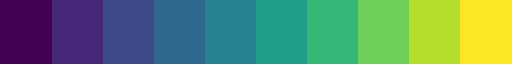

In [13]:
#define progressive colorbar
myvir = ListedColormap(mpl.colormaps['viridis'](np.linspace(0, 1, 10)))
myvir

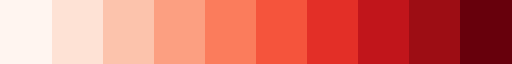

In [14]:
#define progressive colorbar
reds = ListedColormap(mpl.colormaps['Reds'](np.linspace(0, 1, 10)))
reds

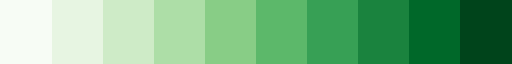

In [15]:
#define progressive colorbar
greens = ListedColormap(mpl.colormaps['Greens'](np.linspace(0, 1, 10)))
greens

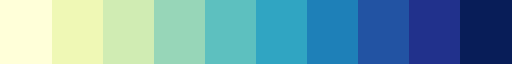

In [16]:
#define progressive colorbar
wet = ListedColormap(mpl.colormaps['YlGnBu'](np.linspace(0, 1, 10)))
wet

# Load files

LAM output analysis.

Simu irr et simu no-irr.

In [17]:
noirr_dir='../../../JZ_simu_outputs/LAM/noirr_2010_2022'
irr_dir='../../../JZ_simu_outputs/LAM/irr_2010_2022'

In [18]:
#open netcdf files for native routing on ORC grid
filename = '{}/SRF/MO/*history.nc'.format(noirr_dir)
ORCnoirr0 = xr.open_mfdataset(filename)
filename = '{}/SRF/MO/*history.nc'.format(irr_dir)
ORCirr0 = xr.open_mfdataset(filename)
ORCirr0

<xarray.Dataset>
Dimensions:                 (lat: 232, lon: 300, veget: 15, soiltyp: 3,
                             solth: 18, nobio: 1, solay: 11, albtyp: 2,
                             time_counter: 156, axis_nbounds: 2)
Coordinates:
  * lat                     (lat) float32 30.0 30.09 30.17 ... 49.83 49.91 50.0
  * lon                     (lon) float32 -13.0 -12.93 -12.86 ... 7.86 7.93 8.0
  * veget                   (veget) float32 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
  * soiltyp                 (soiltyp) float32 1.0 2.0 3.0
  * solth                   (solth) float32 0.0004888 0.001955 ... 33.53 65.56
  * nobio                   (nobio) float32 1.0
  * solay                   (solay) float32 0.0 0.001955 0.005865 ... 0.999 2.0
  * albtyp                  (albtyp) float32 1.0 2.0
    time_centered           (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter            (time_counter) datetime64[ns] 2010-01-16T12:00:00...
Dimensions without coordinates: axis_nbounds
Data variables: (12/127)
    time_centered_bounds    (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds     (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                   (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    Contfrac                (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    swnet                   (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    lwnet                   (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    ...                      ...
    DelSWE_daily            (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delfastr_daily          (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delslowr_daily          (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delstreamr_daily        (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delstock_routing_daily  (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    soilalb_bg              (time_counter, albtyp, lat, lon) float32 dask.array<chunksize=(1, 2, 232, 300), meta=np.ndarray>
Attributes:
    name:         sechiba_history
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Apr-08 20:56:20 GMT
    uuid:         1bf4f5bf-aaac-446e-96f9-b10623398784

In [19]:
#open netcdf files for native routing diag_routing_r.nc (on MERIT grid)
# filename = '../../LAM/{}/SRF/MO/*diag_routing_r.nc'.format(noirr_dir)
# DIAGRnoirr0 = xr.open_mfdataset(filename)
# filename = '../../LAM/{}/SRF/MO/*diag_routing_r.nc'.format(irr_dir)
# DIAGRirr0 = xr.open_mfdataset(filename)
# DIAGRirr0

# File manipulations

In [20]:
#rename time_counter to time all files
ORCnoirr = ORCnoirr0.rename({'time_counter':'time'})
ORCirr = ORCirr0.rename({'time_counter':'time'})
# DIAGRnoirr = DIAGRnoirr0.rename({'time_counter':'time'})
# DIAGRirr = DIAGRirr0.rename({'time_counter':'time'})

In [21]:
#Change dataset names attribute for automatic labeling
ORCirr.attrs['name'] = 'irr'
ORCnoirr.attrs['name'] = 'no_irr'
# DIAGRirr.attrs['name'] = 'DIAGR_irr'
# DIAGRnoirr.attrs['name'] = 'DIAGR_noirr'

In [22]:
#Rename variables in natDIAG_R_month and natDIAG_R
# dict = {
#         'routing_stream_reservoir_r' : 'streamr',
#         'routing_fast_reservoir_r' : 'fastr',
#         'routing_slow_reservoir_r' : 'slowr',
#         'routing_drainage_r' : 'drainage',
#         'routing_runoff_r' : 'runoff',
#         'routing_hydrographs_r' : 'hydrographs',
#         # 'routing_irrigation_r' : 'irrigation',
#         # 'irrig_netereq_r' : 'netirrig'
#         # 'routing_riverflow_r' : 'riverflow',
#         # 'routing_coastalflow_r' : 'coastalflow'
#         }
#change the variables that exist according to the dictionary
# DIAGRnoirr = DIAGRnoirr.rename(dict)
# DIAGRirr = DIAGRirr.rename(dict)

In [23]:
#manually define irrig_deficit as netirrig-irrigation in ORC file
ORCirr['irrig_deficit'] = ORCirr['netirrig'] - ORCirr['irrigation']
#make irrig_deficit units mm/day
ORCirr['irrig_deficit'].attrs['units'] = 'mm/day'
# ORCirr
ORCirr['irrig_frac'] = ORCirr['irrigmap_dyn']/ORCirr['Areas']

In [24]:
# limit data to lon and lat of interest (-13,6) and (32,49)
ORCirr = ORCirr.sel(lon=slice(-13,6),lat=slice(32,49))
ORCnoirr = ORCnoirr.sel(lon=slice(-13,6),lat=slice(32,49))

In [25]:
# Select the JJA months (June, July, August)
# ORCirr = ORCirr.sel(time=ORCirr['time.month'].isin([6, 7, 8]))
# ORCnoirr = ORCnoirr.sel(time=ORCnoirr['time.month'].isin([6, 7, 8]))

In [26]:
#create a masks of data points where irrig_frac >0.01
irr_mask = (ORCirr['irrigmap_dyn']/ORCirr['Areas'])>0.05

In [27]:
# (ORCirr['irrigmap_dyn']/ORCirr['Areas']).mean().values

In [28]:
mORCirr=ORCirr.where(irr_mask)
mORCnoirr=ORCnoirr.where(irr_mask)

In [48]:
mORCirr.attrs['name'] = 'irr'
mORCnoirr.attrs['name'] = 'no_irr'

# Maps

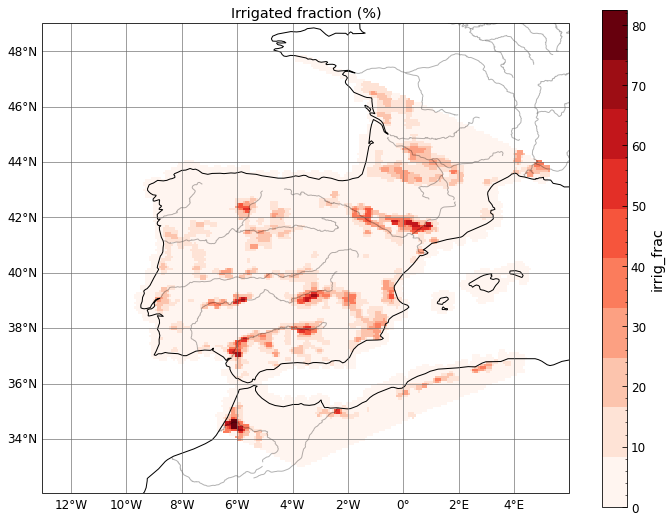

In [42]:
#Display map of var for ds
var='irrig_frac'
ds = ORCirr
color_map=reds
max_value=None
plotvar = ds[var].mean(dim='time') *100 #*3600*24
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=color_map, vmax=max_value)
# plt.title(var + ' ({}, {})' .format(ds.attrs['name'], ds[var].attrs['units']))
# plt.title('{} ({})' .format(ds[var].long_name, ds[var].attrs['units']))
plt.title('Irrigated fraction (%)')# ({})' .format(ds[var].attrs['units']))
plt.tight_layout()

Text(0.5, 1.0, '2m-temperature difference (irr - no_irr, K)')

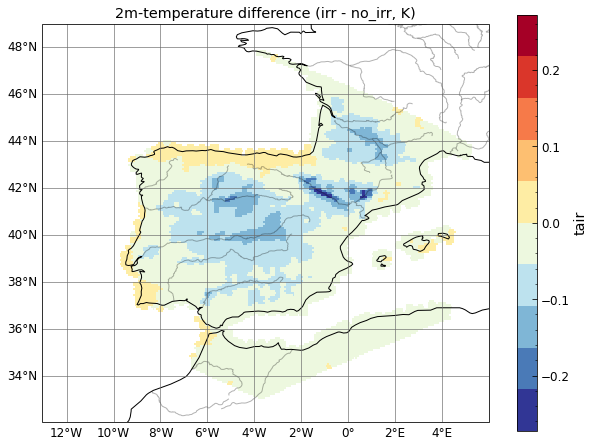

In [46]:
#Diff map
var='tair'
max_value=None
ds1=ORCirr
ds2=ORCnoirr
# ds1=DIAGRirr
# ds2=DIAGRnoirr
#compute diff between ds1 and ds2
diff = (ds1[var]-ds2[var]).mean(dim='time') #* 3600 * 24
#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)

diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=max_value)
# plt.title(var + ' difference (' + ds1.name + ' - ' + ds2.name + ', ' + ds1[var].attrs['units'] + ')')
plt.title('2m-temperature difference (irr - no_irr, K)')

In [ ]:
# Display 2 maps of var
var = 'plul'
maxvalue=2
color_map=reds

ds1 = ORCirr
ds2 = ORCnoirr
# ds1=DIAGRirr
# ds2=DIAGRnoirr
plotvar_1 = ds1[var].mean(dim='time') *3600*24
plotvar_2 = ds2[var].mean(dim='time') #*3600*24

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(var + ' ({})'.format(ds1[var].units))

# Plot for std dataset
axs[0].coastlines()
plotvar_1.plot(ax=axs[0], transform=ccrs.PlateCarree(), cmap=color_map, vmax=maxvalue)
axs[0].set_title(f'{var} ({ds1.name})')

# Plot for natORC dataset
axs[1].coastlines()
plotvar_2.plot(ax=axs[1], transform=ccrs.PlateCarree(), cmap=color_map, vmax=maxvalue)
axs[1].set_title(f'{var} ({ds2.name})')

In [ ]:
#Relative diff map
var='sfcWind'
maxvalue=None
ds1=ORCirr
ds2=ORCnoirr
#compute diff between ds1 and ds2
diff = (ds1[var]-ds2[var]).mean(dim='time')
rel_diff = ((ds1[var]-ds2[var] + 1E-16) / (ds2[var] + 1E-16)).mean(dim='time') * 100
# Transform rel_diff using log10
rel_diff_log = np.log10(rel_diff)
#display map
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
rel_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=maxvalue)
# rel_diff_log.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb)
plt.title(var + ' relative difference (' + ds1.name + ' - ' + ds2.name + '; %)')
# plt.title('Gross primary production relative difference (%)')

Text(0.5, 1.0, 'irrigation (ORC_irr)')

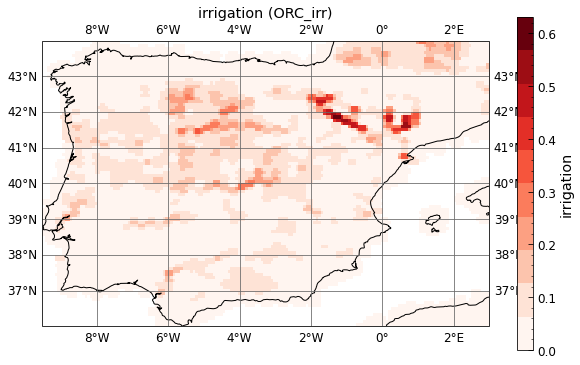

In [59]:
#Display map of var for ds on restricted area
var='irrigation'
ds = ORCirr
# ds = std
latmin=36
latmax=44
lonmin=-9.5
lonmax=3

#restrict ds to latmin, latmax, lonmin, lonmax
ds = ds.where(ds.lat >= latmin, drop=True)
ds = ds.where(ds.lat <= latmax, drop=True)
ds = ds.where(ds.lon >= lonmin, drop=True)
ds = ds.where(ds.lon <= lonmax, drop=True)
plotvar = ds[var].mean(dim='time')
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=reds)
plt.title(var + ' (' + ds.name + ')')

In [29]:
#Display map of var for ds averaged on a given year
var='evap'
year=2012
ds = ORCnoirr
# ds = ds.where(ds['time.year'] == year, drop=True)
plotvar = ds[var].mean(dim='time')
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=myvir)
plt.title(var + ' (' + ds.name + ')')

KeyError: 'hydrographs'

# Time series

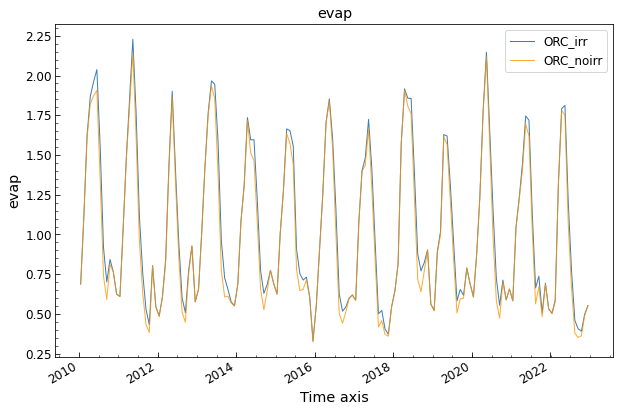

In [39]:
#Average time series
var='evap'
ds1=ORCirr
ds2=ORCnoirr
# ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
# ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ds1[var].mean(dim=['lon','lat']).plot(ax=ax, label=ds1.name)
ds2[var].mean(dim=['lon','lat']).plot(ax=ax, label=ds2.name)
plt.title(var)
plt.legend()

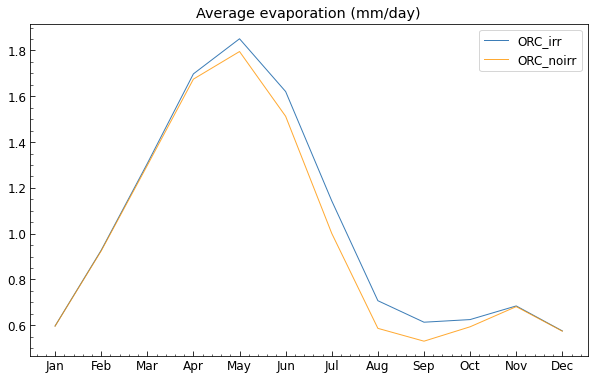

In [54]:
#Average seasonnal cycle
var='evap'
ds1=ORCirr
ds2=ORCnoirr
# ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
# ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()

ds1[var].mean(dim=['lon','lat']).groupby('time.month').mean(dim='time').plot(ax=ax, label=ds1.name)
ds2[var].mean(dim=['lon','lat']).groupby('time.month').mean(dim='time').plot(ax=ax, label=ds2.name)

months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months)
ax.set_ylabel('')
ax.set_xlabel('')
# plt.title(var)
plt.title('Average evaporation (mm/day)')
plt.legend()

# Hydrographs en un point

In [ ]:
river_coordinates = {
    'Ebre': {'lon': 0.75, 'lat': 40.75},
    'Minho': {'lon': -8.75, 'lat': 42.25},
    'Tage': {'lon': -9.25, 'lat': 39.25},
    'Douro': {'lon': -8.75, 'lat': 41.25},
    'Guadiana': {'lon': -7.25, 'lat': 38.25},
    'Guadalquivir': {'lon': -6.25, 'lat': 36.75}
}
river_coordinates_native = {
    'Ebre': {'lon': 0.86, 'lat': 40.725},
    'Minho': {'lon': -8.875, 'lat': 41.86},
    'Tage': {'lon': -9.175, 'lat': 38.6875},
    'Douro': {'lon': -8.675, 'lat': 41.1375},
    'Guadiana': {'lon': -7.39, 'lat': 37.175},
    'Guadalquivir': {'lon': -6.34, 'lat': 36.79}
}

In [ ]:
#Time series
year_min=2003
year_max=2012
# Ebre
# lon=0.75
# lat=40.75
# lon=0.86
# lat=40.725
#Minho
# lat=41.86
# lon=-8.875
# # Tage
# lon=-9.25
# lat=39.25
# lon=-9.175
# lat=38.6875
# Douro
# lon=-8.75
# lat=41.25
# lon=-8.675
# lat=41.1375
# # Guadiana
# lon=-7.25
# lat=38.25
# lon=-7.39
# lat=37.175
# # Guadalquivir
# lon=-6.25
# lat=36.75
lon=-6.34
lat=36.79

var="hydrographs"
ds1=std
ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
ds2=natDIAG_R
ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
#plot the time series of hydrographs at the point (lon,lat)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ax.set_ylabel('hydrographs')
# ds1[var].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label=ds1.name)
ds2[var].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label=ds2.name)
# ds2['runoff'].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label='runoff')
plt.title('hydrographs at (' + str(lon) + ',' + str(lat) + '), m³/s')
plt.legend()

In [ ]:
#Time series
year_min=2003
year_max=2012
lon=-8.875
lat=41.86
ds1=natDIAG_R
ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
#plot the time series of hydrographs at the point (lon,lat)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ds1['runoff'].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label='runoff',c='green')
ds1['drainage'].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label='drainage',c='brown')
# ['rain'].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label='rainfall',c='blue')
plt.title('Runoff and drainage at (' + str(lon) + ',' + str(lat) + '), mm/d')
plt.legend()

In [ ]:
#Cycle saisonnier (moyenne par jour de l'année)
var="hydrographs"
#Ebre
# lon=0.75
# lat=40.75
# # Tage
# lon=-9.25
# lat=39.25
# # Douro
# lon=-8.75
# lat=41.25
# # Guadiana
lon=-7.25
lat=38.25
# # Guadalquivir
# lon=-6.25
# lat=36.75
ds1=std
ds2=natDIAG_R
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ax.set_xlabel('month')
ax.set_ylabel('hydrographs')
ax.set_title('hydrographs at (' + str(lon) + ',' + str(lat) + ')')
#compute the annual cycle of hydrographs at the point (lon,lat)
ds1[var].sel(lon=lon, lat=lat, method='nearest').groupby('time.dayofyear').mean(dim='time').plot(ax=ax, label=ds1.name)
ds2[var].sel(lon=lon, lat=lat, method='nearest').groupby('time.dayofyear').mean(dim='time').plot(ax=ax, label=ds2.name)
plt.legend()

In [ ]:
#cycle saisonnier pour 6 points de grille
var = "hydrographs"
ds1 = std
ds2 = natDIAG_R

# Create subplots for each river in a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over rivers and plot hydrographs
for i, (river, coordinates) in enumerate(river_coordinates.items()):
    lon = coordinates['lon']
    lat = coordinates['lat']
    
    ax = axes[i]

    #Compute the annual cycle of hydrographs at the point (lon, lat) for each dataset
    ds1[var].sel(lon=lon, lat=lat, method='nearest').groupby('time.month').mean(dim='time').plot(ax=ax, label=ds1.name)

for i, (river, coordinates) in enumerate(river_coordinates_native.items()):
    lon = coordinates['lon']
    lat = coordinates['lat']
    
    ax = axes[i]

    # Compute the annual cycle of hydrographs at the point (lon, lat) for each dataset
    ds2[var].sel(lon=lon, lat=lat, method='nearest').groupby('time.month').mean(dim='time').plot(ax=ax, label=ds2.name)
    
    ax.legend()
    #set subplot title to river name
    ax.set_title(river)

# Remove any remaining empty subplots
for i in range(len(river_coordinates), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Cycle saisonnier du débit à l'exutoire (m³/s, 2003-2012)")
plt.tight_layout()

In [ ]:
#série temporelle pour 6 points de grille
var = "hydrographs"
ds1 = natORC
ds2 = natDIAG_R

# Create subplots for each river in a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over rivers and plot hydrographs
for i, (river, coordinates) in enumerate(river_coordinates.items()):
    lon = coordinates['lon']
    lat = coordinates['lat']
    
    ax = axes[i]

    # Compute the annual cycle of hydrographs at the point (lon, lat) for each dataset
    # ds1[var].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label=ds1.name)

for i, (river, coordinates) in enumerate(river_coordinates_native.items()):
    lon = coordinates['lon']
    lat = coordinates['lat']
    
    ax = axes[i]

    # Compute the annual cycle of hydrographs at the point (lon, lat) for each dataset
    ds2[var].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label=ds2.name)
    
    ax.legend()
    #set subplot title to river name
    ax.set_title(river)

# Remove any remaining empty subplots
for i in range(len(river_coordinates), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Série temporelle du débit à l'exutoire (m³/s)")
plt.tight_layout()